Exploratory Data Analysis (EDA)

Load Data

In [1]:
import pandas as pd

df = pd.read_csv("../Data/MachineLearningRating_v3.txt", sep='|')


C:\Users\የአብትዕግስት\AppData\Local\Temp\ipykernel_4960\811398441.py:3: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/MachineLearningRating_v3.txt", sep='|')


In [13]:
print(df.head())

   UnderwrittenCoverID  PolicyID TransactionMonth  IsVATRegistered  \
0               145249     12827       2015-03-01             True   
1               145249     12827       2015-05-01             True   
2               145249     12827       2015-07-01             True   
3               145255     12827       2015-05-01             True   
4               145255     12827       2015-07-01             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ... CoverCategory   CoverType            CoverGroup  \
0  Current account  ...    Windscreen  Windscreen  Comprehensive - Taxi

In [2]:
print(df.shape)
print(df.columns.tolist())

(1000098, 52)
['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims']


1. What is the overall Loss Ratio?

1.1. Check for Zero or Negative Values

In [4]:
print("Number of zero or negative TotalPremium:", ((df['TotalPremium'] <= 0)).sum())
print("Number of negative TotalClaims:", ((df['TotalClaims'] < 0)).sum())

Number of zero or negative TotalPremium: 381922
Number of negative TotalClaims: 5


1.2. Handle Division Safely
<p>np.where() to avoid division by zero:</p>

In [5]:
import numpy as np

# Compute Loss Ratio safely
df['LossRatio'] = np.where(
    df['TotalPremium'] > 0,
    df['TotalClaims'] / df['TotalPremium'],
    np.nan  # or 0 if no premium means no exposure
)

1.3. Drop or Impute NaNs

In [6]:
# Option A: Drop rows where LossRatio is NaN
df_clean = df.dropna(subset=['LossRatio'])

# Option B: Fill NaN with 0 (e.g., no premium means no claim risk)
df['LossRatio'] = df['LossRatio'].fillna(0)

1.4. Compute Average Loss Ratio

In [7]:
avg_loss_ratio = df_clean['LossRatio'].mean()
print(f"Average Loss Ratio: {avg_loss_ratio:.2%}")

Average Loss Ratio: 35.00%


2. How does it vary by Province, VehicleType, Gender?

In [8]:
loss_by_province = df.groupby('Province')['LossRatio'].mean().sort_values(ascending=False)
loss_by_vehicle = df.groupby('VehicleType')['LossRatio'].mean().sort_values(ascending=False)
loss_by_gender = df.groupby('Gender')['LossRatio'].mean().sort_values(ascending=False)

print("Loss Ratio by Province:\n", loss_by_province.head(5))
print("\nLoss Ratio by Vehicle Type:\n", loss_by_vehicle.head(5))
print("\nLoss Ratio by Gender:\n", loss_by_gender)

Loss Ratio by Province:
 Province
Gauteng         0.262216
Limpopo         0.252857
Mpumalanga      0.235858
Western Cape    0.193640
North West      0.178830
Name: LossRatio, dtype: float64

Loss Ratio by Vehicle Type:
 VehicleType
Heavy Commercial     0.457233
Light Commercial     0.364845
Medium Commercial    0.305509
Passenger Vehicle    0.208682
Bus                  0.000000
Name: LossRatio, dtype: float64

Loss Ratio by Gender:
 Gender
Female           0.247919
Not specified    0.218548
Male             0.157443
Name: LossRatio, dtype: float64


3. Distributions of key financial variables (TotalPremium, TotalClaims)

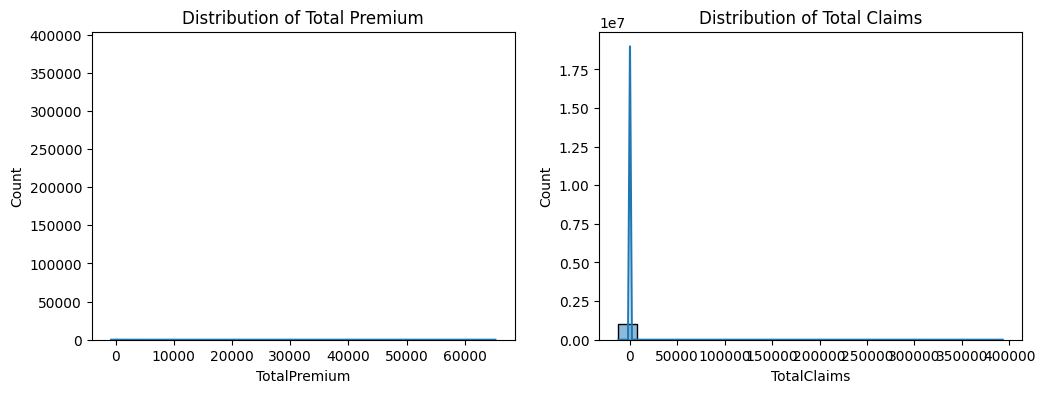

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['TotalPremium'], kde=True)
plt.title("Distribution of Total Premium")

plt.subplot(1, 2, 2)
sns.histplot(df['TotalClaims'], kde=True)
plt.title("Distribution of Total Claims")
plt.show()

4. Are there outliers in TotalClaims or CustomValueEstimate?

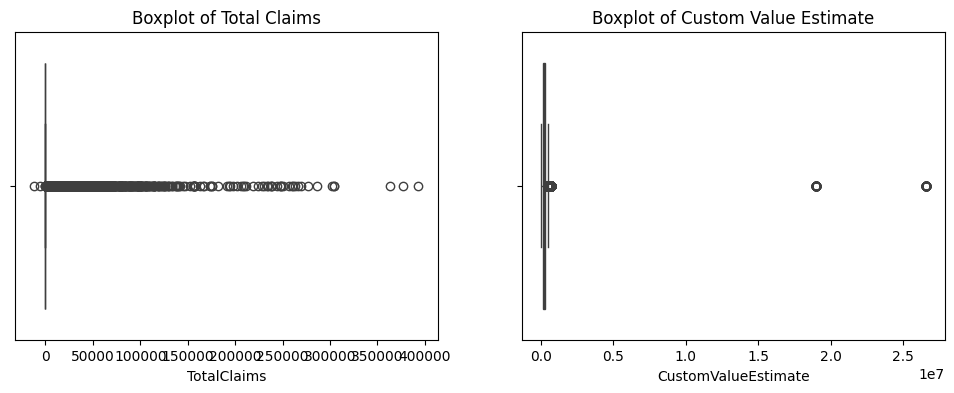

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['TotalClaims'])
plt.title("Boxplot of Total Claims")

plt.subplot(1, 2, 2)
sns.boxplot(x=df['CustomValueEstimate'])
plt.title("Boxplot of Custom Value Estimate")
plt.show()

5. Temporal Trends (TransactionMonth vs TotalClaims/TotalPremium)

C:\Users\የአብትዕግስት\AppData\Local\Temp\ipykernel_4960\1926481292.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_trend = df.resample('M', on='TransactionMonth').agg({


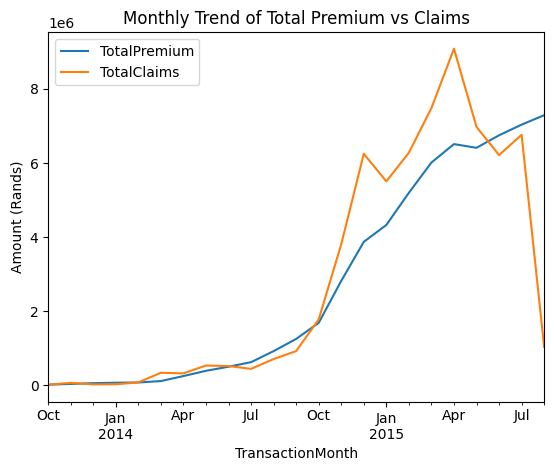

In [11]:
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])

monthly_trend = df.resample('M', on='TransactionMonth').agg({
    'TotalPremium': 'sum',
    'TotalClaims': 'sum'
})

monthly_trend.plot()
plt.title("Monthly Trend of Total Premium vs Claims")
plt.ylabel("Amount (Rands)")
plt.show()

6. Which vehicle makes/models are associated with highest/lowest claim amounts?

In [14]:
top_makes = df.groupby('make')['TotalClaims'].mean().sort_values(ascending=False).head(10)
print("Top Makes by Average Claim Amount:\n", top_makes)

top_models = df.groupby(['make', 'Model'])['TotalClaims'].mean().sort_values(ascending=False).head(10)
print("\nTop Models by Average Claim Amount:\n", top_models)

Top Makes by Average Claim Amount:
 make
SUZUKI                                 419.634546
JMC                                    191.684795
HYUNDAI                                174.215195
MARCOPOLO                              156.794806
AUDI                                   137.843083
POLARSUN                               134.044800
B.A.W                                  132.934016
FIAT                                   108.625642
BMW                                     90.558050
IVECO                                   89.667017
Name: TotalClaims, dtype: float64

Top Models by Average Claim Amount:
 make                                 Model                      
TOYOTA                               L/CRUISER FJ 4.0 V6 CRUISER    5340.970273
HYUNDAI                              H-1 2.5 CRDI WAGON A/T         4118.181043
FIAT                                 DUCATO 2.3 JTD VETRATO         1014.681021
VOLKSWAGEN                           POLO VIVO 1.6 5Dr               827.558882
ME

7. Which Claim Frequency by Gender are associated with highest/lowest claim amounts?

In [18]:
df['HadClaim'] = df['TotalClaims'] > 0
claim_freq_by_gender = df.groupby('Gender')['HadClaim'].mean()
print("Claim Frequency by Gender:\n", claim_freq_by_gender)
claim_sev_by_gender = df[df['HadClaim'] == True].groupby('Gender')['TotalClaims'].mean()
print("\nClaim Severity by Gender:\n", claim_sev_by_gender)

Claim Frequency by Gender:
 Gender
Female           0.002073
Male             0.002195
Not specified    0.002833
Name: HadClaim, dtype: float64

Claim Severity by Gender:
 Gender
Female           17874.721303
Male             14858.552294
Not specified    23530.667678
Name: TotalClaims, dtype: float64


Visualizations

Plot 1: Loss Ratio by Province

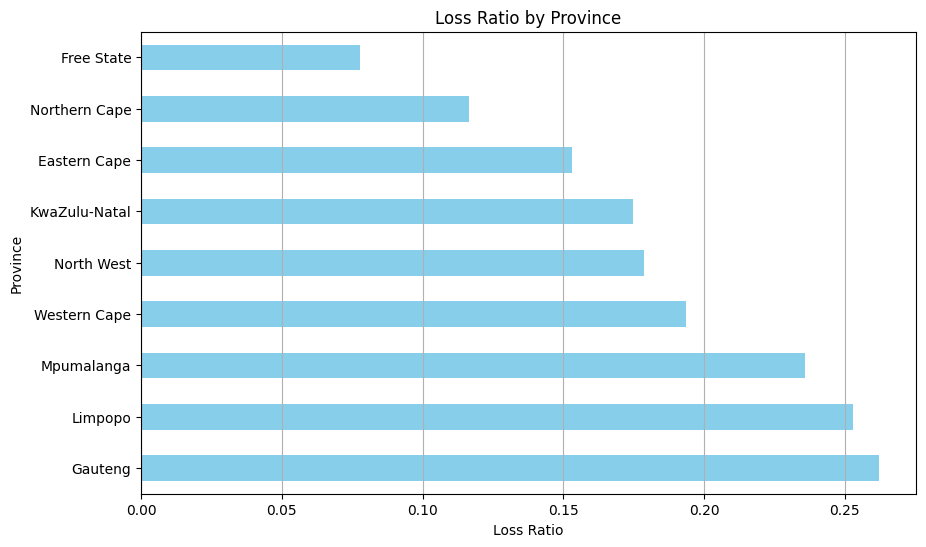

In [15]:
loss_by_province.plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title("Loss Ratio by Province")
plt.xlabel("Loss Ratio")
plt.ylabel("Province")
plt.grid(axis='x')
plt.show()

Plot 2: Correlation Heatmap

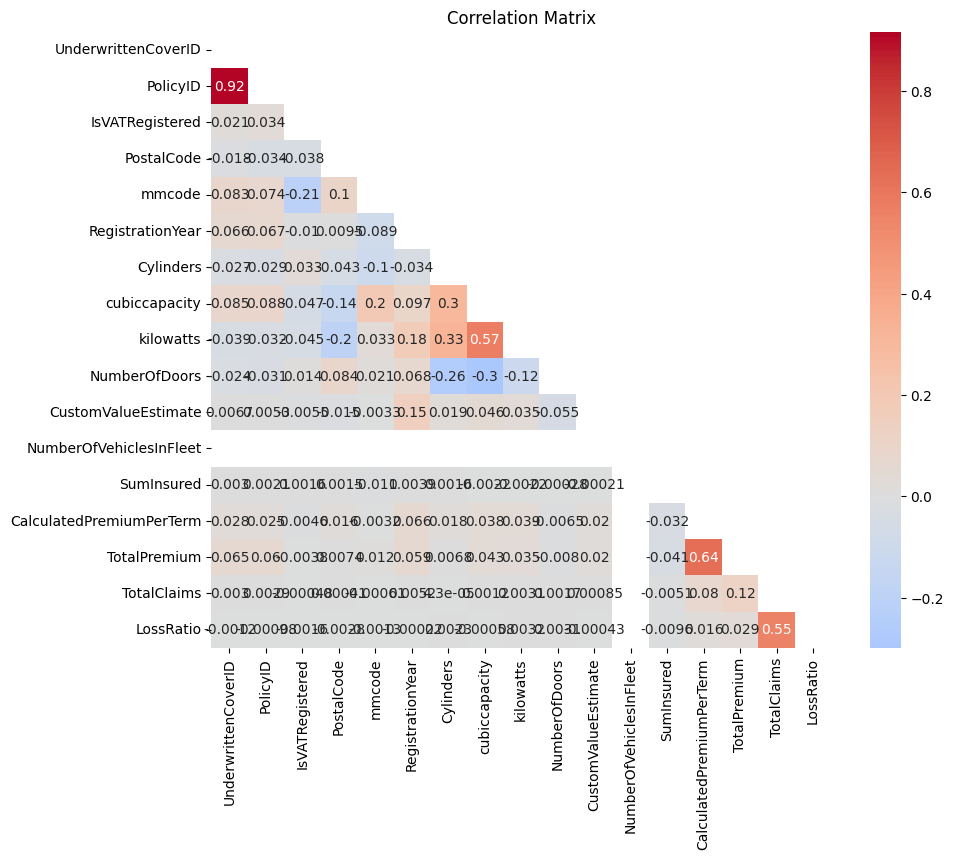

In [16]:
import numpy as np

corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

Plot 3: Top 5 High-Risk Vehicle Models

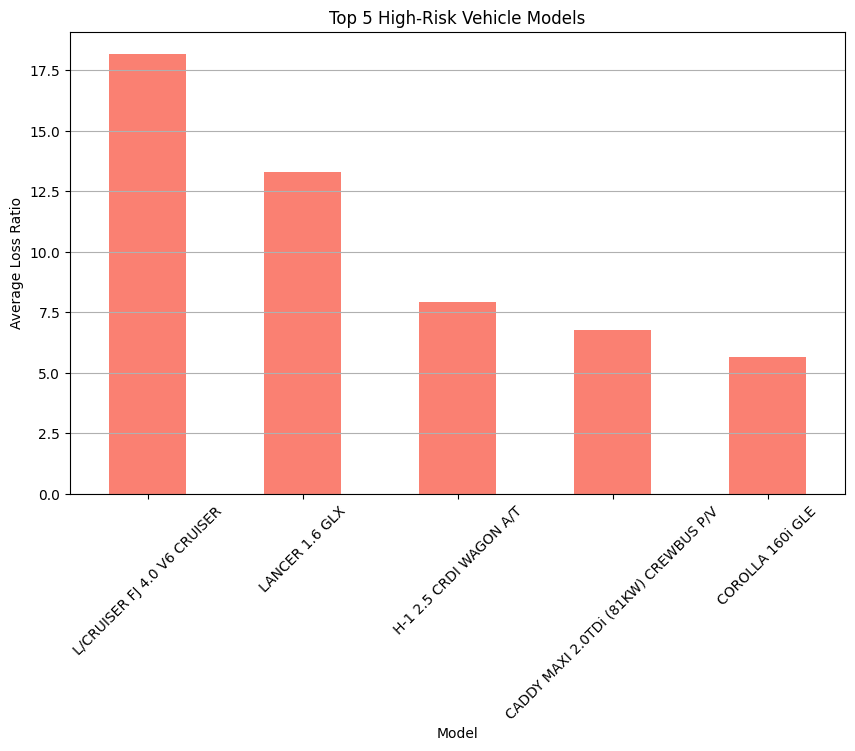

In [17]:
top_5_models = df.groupby('Model')['LossRatio'].mean().sort_values(ascending=False).head(5)
top_5_models.plot(kind='bar', color='salmon', figsize=(10, 6))
plt.title("Top 5 High-Risk Vehicle Models")
plt.ylabel("Average Loss Ratio")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Summary of Findings

## 📊 Key Insights from EDA

- **Overall Loss Ratio**: 35%
- **Highest Risk Provinces**: Gauteng, Limpopo, and Mpumalanga
- **Lowest Risk Province**: Northern Cape
- **Most Risky Vehicle Types**:
  - Heavy Commercial: 0.457233
  - Light Commercial: 0.364845
  - Medium Commercial: 0.305509
- **Claim Frequency by Gender**:
  - Female: 0.002073
  - Male: 0.002195
  - Not Specified: 0.002833  
  _→ No significant difference observed_
- **Temporal Trend**: Gradual decrease in claims over time
- **Outliers**: Some vehicles have high `CustomValueEstimate` but low claims — potential opportunity for underwriting optimization